In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon
from planners.basic_prm import BasicPRM


In [2]:
scene = {
    "wall": LineString([(6, 18), (6, 8), (16, 8), (16, 18)]).buffer(1.0)
}

limits = ((0, 22), (0, 22))  # Sampling-Bereich


In [3]:
planner = BasicPRM(scene, limits)

In [4]:
start = [[2, 20]]
goal = [[20, 2]]

config = {
    "numNodes": 250,
    "radius": 3.0
}


In [5]:
path = planner.plan_path(start, goal, config)
print("Pfad gefunden!" if path else "Kein Pfad gefunden.")
print("Knoten im Pfad:", path)

coords = planner.get_path_coordinates(path)
print("Pfadkoordinaten:")
for pt in coords:
    print(pt)


Pfad gefunden!
Knoten im Pfad: ['start', 3, 1, 21, 36, 55, 17, 114, 14, 41, 31, 37, 75, 62, 63, 9, 40, 20, 'goal']
Pfadkoordinaten:
[ 2 20]
[ 3.86758178 18.85841546]
[ 4.02978693 17.50695711]
[ 2.46319898 15.73424547]
[ 4.14395271 14.20596638]
[ 3.1726204 12.1345705]
[3.11896163 9.34673217]
[2.49196439 6.98723004]
[4.65119124 5.74219432]
[6.73809321 3.78617198]
[9.10630742 3.91005041]
[9.52923006 6.31510554]
[11.85272622  6.83481644]
[13.5598396   4.69056476]
[15.76143744  4.53353234]
[18.29997211  4.94361332]
[20.78676873  4.22729842]
[21.12781302  3.29164453]
[20  2]


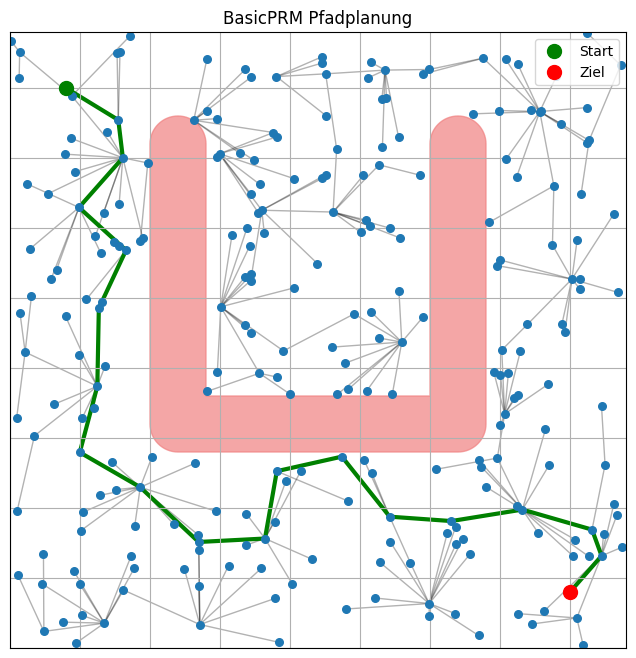

In [6]:
def visualize_path(prm, path, scene, limits):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Hindernisse zeichnen
    for shape in scene.values():
        xs, ys = shape.exterior.xy if hasattr(shape, 'exterior') else shape.xy
        ax.fill(xs, ys, color='lightcoral', alpha=0.7)

    pos = nx.get_node_attributes(prm.graph, 'pos')

    # Alle Knoten
    nx.draw_networkx_nodes(prm.graph, pos, node_size=30, ax=ax)
    nx.draw_networkx_edges(prm.graph, pos, alpha=0.3, ax=ax)

    # Pfad markieren
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(prm.graph, pos, edgelist=path_edges, width=3, edge_color='green', ax=ax)

    ax.plot(start[0][0], start[0][1], "go", markersize=10, label="Start")
    ax.plot(goal[0][0], goal[0][1], "ro", markersize=10, label="Ziel")

    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend()
    plt.title("BasicPRM Pfadplanung")
    plt.show()

visualize_path(planner, path, scene, limits)


In [7]:
from scipy.spatial.distance import euclidean

if path:
    coords = planner.get_path_coordinates(path)
    length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:]))
    print(f"Pfadlänge: {length:.2f}")
else:
    print("Keine Pfadlänge berechenbar.")


Pfadlänge: 41.07
